In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from random import randrange
import cv2 as cv
import pickle


from tensorflow import keras
from keras.layers import *
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# our num of classes
NUM_CLASSES = 2

# Fixed for color images
CHANNELS = 3

IMAGE_RESIZE = 180
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
# BATCH_SIZE_TRAINING = 100
# BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1


In [3]:
GOOGLE_DATA_FOLDER='/home/fra/Scrivania/Deepfake-Detection/dataset/GoogleAi'

#input folder google
ORIGINAL_FOLDER='original_sequences'
MANIPULATED_FOLDER='fake_sequences'

#output folder preprocess google
IMG_ORIGINAL_FOLDER  ='/home/fra/Scrivania/Deepfake-Detection/dataset/preprocess-output/png_real'
IMG_MANIPULATED_FOLDER='/home/fra/Scrivania/Deepfake-Detection/dataset/preprocess-output/png_fake'

In [5]:
from keras.preprocessing.image import img_to_array, load_img


train_original    = os.listdir(IMG_ORIGINAL_FOLDER)
train_manipulated = os.listdir(IMG_MANIPULATED_FOLDER)


X = []
Y = []

FRAME_X_VIDEO=5

MAX_VIDEO_REAL=200
MAX_VIDEO_FAKE=200

count_real=0


while count_real<MAX_VIDEO_REAL:
    next_video_index = randrange(0,len(train_original))
    #randomly we choose a video_dir from the train folder
    video_dir=train_original[next_video_index]
    #randomly from that video_folder we choose some frame for the training
    frames_taken=0
    candidate_frame= list(os.listdir(os.path.join(IMG_ORIGINAL_FOLDER, video_dir)))
    if len(candidate_frame)>20:
        count_real+=1        
        while frames_taken<FRAME_X_VIDEO:
            random_index=randrange(0,len(candidate_frame))  
            X.append(img_to_array(
                load_img(
                os.path.join(IMG_ORIGINAL_FOLDER, video_dir,candidate_frame[random_index]),
                target_size=(128, 128) )
                    )            )
            Y.append(0)
            
            frames_taken+=1
            #remove the selected frame
            del candidate_frame[random_index]
        #remove the selected video from the frontier
        del train_original[next_video_index]

count_fake=0        
        
while count_fake<MAX_VIDEO_FAKE: 
    next_video_index = randrange(0,len(train_original))
    #randomly we choose a video_dir from the train folder
    video_dir=train_manipulated[next_video_index]
    #randomly from that video_folder we choose some frame for the training
    frames_taken=0
    candidate_frame= list(os.listdir(os.path.join(IMG_MANIPULATED_FOLDER, video_dir)))
    if len(candidate_frame)>20:
        count_fake+=1        
        while frames_taken<FRAME_X_VIDEO:
            random_index=randrange(0,len(candidate_frame))  
            X.append(img_to_array(
                load_img(
                os.path.join(IMG_MANIPULATED_FOLDER, video_dir,candidate_frame[random_index]),
                target_size=(128, 128) )
                    )            )
            Y.append(0)
            
            frames_taken+=1
            #remove the selected frame
            del candidate_frame[random_index]
        #remove the selected video from the frontier
        del train_manipulated[next_video_index]    

 
data= {}
data["X_train"] = X
data["Y_train"] = Y


output = open('train_400_google.pkl', 'wb')
pickle.dump(data, output)
output.close()
print("DATA Saved")   

DATA Saved


In [13]:
# load data file
pkl_file1 = open('train_500_google.pkl', 'rb')
train = pickle.load(pkl_file1)
pkl_file1.close()
X = train["X_train"]
Y = train["Y_train"]

# pkl_file2 = open('validation_100_kaggle.pkl', 'rb')
# val = pickle.load(pkl_file2)
# pkl_file2.close()
# X_val = val["X_val"]
# Y_val = val["Y_val"]


In [14]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

# #Reshape
X = X.reshape(-1, 128, 128, 3)

# #Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [15]:
print(X_train.shape,Y_train.shape,X_val.shape)

(2000, 128, 128, 3) (2000, 2) (500, 128, 128, 3)


In [7]:
#optimizer

#ada_delta
ada_delta = optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-07 )

#adam
adam=optimizers.Adam(lr=1e-5, decay=1e-6)

#sgd with momentum
epochs=10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)


In [8]:
#define a new activation

from keras.backend import sigmoid

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})


In [16]:
from keras.applications.resnet50 import ResNet50

resnet = ResNet50(include_top = False, pooling = 'avg', weights='imagenet')
resnet.trainable=True

model = Sequential()
model.add(resnet)
model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 24,112,770
Trainable params: 24,059,650
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy', metrics = LOSS_METRICS)


early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0)


In [18]:
history1=model.fit(X_train, Y_train, 
                    batch_size = 100, 
                    epochs = 10, 
                    validation_data = (X_val, Y_val), 
                    verbose = 1)

Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 534s 267ms/step - loss: 0.0646 - accuracy: 0.9705 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
2000/2000 [==============================] - 482s 241ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
2000/2000 [==============================] - 481s 240ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
2000/2000 [==============================] - 484s 242ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
2000/2000 [==============================] - 488s 244ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
2000/2000 [==============================] - 499s 250ms/step - loss: 1.1921e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
2000/2000 

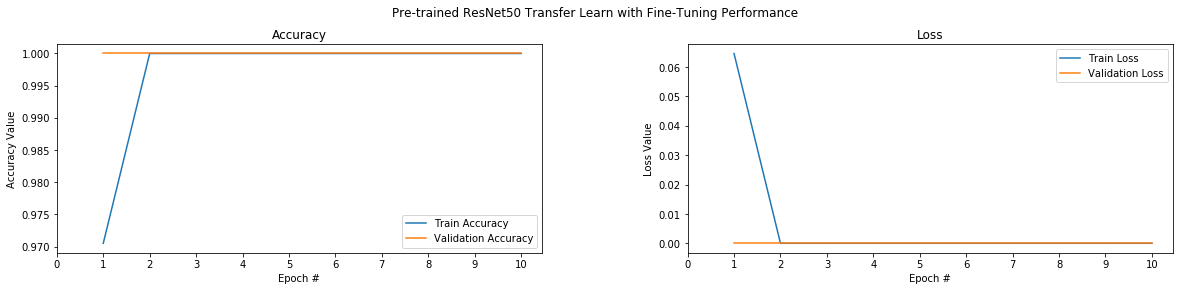

In [19]:
EPOCHS=10



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained ResNet50 Transfer Learn with Fine-Tuning Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history1.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
model.save("resnet50_sgd_(500)_googlr_model.h5")

In [ ]:
#RESNET152V2



In [15]:
from keras.applications import ResNet152V2

resnet152V2=ResNet152V2(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling='avg')

model152V2 = Sequential()
model152V2.add(resnet152V2)
model152V2.add(Dense(256, activation='relu'))
model152V2.add(Dropout(.5))
model152V2.add(Dense(units=2, activation='softmax'))
model152V2.summary()


model152V2.compile(optimizer = sgd,
              loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 2048)              58331648  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 58,856,706
Trainable params: 58,712,962
Non-trainable params: 143,744
_________________________________________________________________


In [16]:
history2=model152V2.fit(X_train, Y_train, 
                    batch_size = 50, 
                    epochs = 10, 
                    validation_data = (X_val, Y_val), 
                    verbose = 1)

Train on 600 samples, validate on 150 samples
Epoch 1/10
600/600 [==============================] - 484s 807ms/step - loss: 0.0662 - accuracy: 0.9683 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
600/600 [==============================] - 325s 542ms/step - loss: 3.7756e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
600/600 [==============================] - 326s 543ms/step - loss: 2.1612e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
600/600 [==============================] - 328s 546ms/step - loss: 2.9612e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
600/600 [==============================] - 336s 560ms/step - loss: 8.4735e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
600/600 [==============================] - 366s 610ms/step - loss: 6.7869e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
600/600 [==============

In [17]:
model152V2.save("resnet152V2_sgd(150)_model.h5")

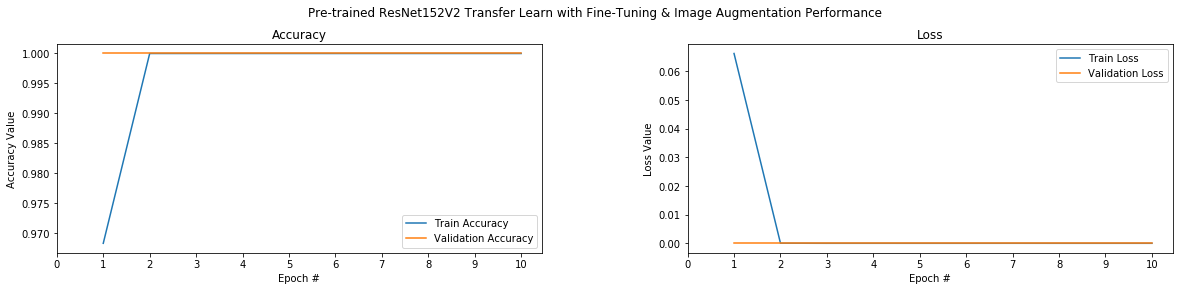

In [18]:
EPOCHS=10



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained ResNet152V2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#inceptionresnetv3


In [9]:
from keras.applications import InceptionResNetV2

inceptionResNet=InceptionResNetV2(
    include_top=False, weights='imagenet', pooling='avg')

model3 = Sequential()
model3.add(inceptionResNet)
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(.5))
model3.add(Dense(units=2, activation='softmax'))
model3.summary()


model3.compile(optimizer = sgd,
              loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 54,730,722
Trainable params: 54,670,178
Non-trainable params: 60,544
_________________________________________________________________


In [10]:
history3=model3.fit(X_train, Y_train, 
                    batch_size = 100, 
                    epochs = 10, 
                    validation_data = (X_val, Y_val), 
                    verbose = 1)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 558s 349ms/step - loss: 0.0548 - accuracy: 0.9631 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1600/1600 [==============================] - 475s 297ms/step - loss: 2.2352e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1600/1600 [==============================] - 483s 302ms/step - loss: 1.7136e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1600/1600 [==============================] - 484s 303ms/step - loss: 1.7658e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1600/1600 [==============================] - 471s 294ms/step - loss: 2.3097e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1600/1600 [==============================] - 473s 295ms/step - loss: 5.9605e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1600/1600 

In [11]:
model3.save("InceptionResnetv2_sgd(400)_model.h5")

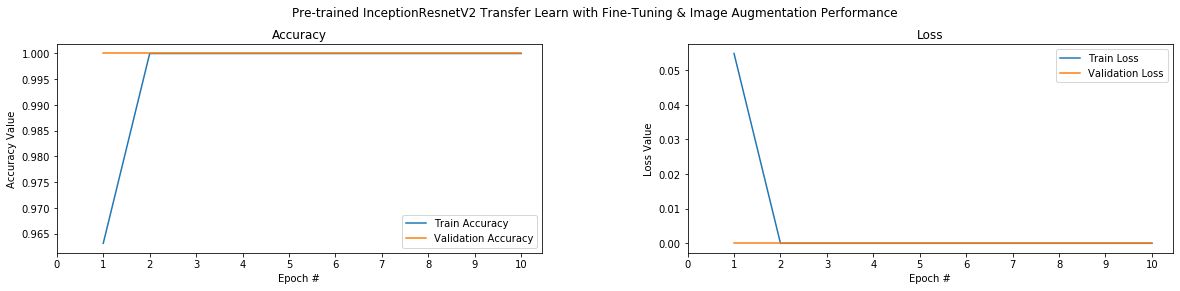

In [12]:
EPOCHS=10



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResnetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")